In [1]:
import torch
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pyro
import pyro.distributions as dist
import zuko
from tqdm import tqdm

sns.set(style="white", context="notebook", palette="deep", color_codes=True)

/home/cbd/.cache/pypoetry/virtualenvs/bayes-air-GdHwFLEb-py3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Generate a bunch of samples from a normal distribution
torch.manual_seed(0)
pyro.set_rng_seed(0)
N_nominal = 25
N_failure = 2
nominal_mean = 0.0
failure_mean = 1.0
std = 0.5

nominal_samples = torch.normal(nominal_mean, std, (N_nominal,))
failure_samples = torch.normal(failure_mean, std, (N_failure,))

df = pd.concat(
    [
        pd.DataFrame({"x": nominal_samples, "type": "nominal"}),
        pd.DataFrame({"x": failure_samples, "type": "failure"}),
    ]
)

In [3]:
# Define the toy model
def original_model(n_samples, x=None):  # last arg needed for flow-based GAVI
    mean = pyro.sample("mean", dist.Normal(0.0, 100.0))
    sigma = torch.exp(pyro.sample("log_std", dist.Normal(0.0, 100.0)))

    with pyro.plate("data", n_samples):
        return pyro.sample("x", dist.Normal(mean, sigma), obs=x)

In [4]:
def elbo_loss(model, guide, context, num_particles=10, *model_args, **model_kwargs):
    elbo = torch.tensor(0.0)
    guide_dist = guide(context)
    for _ in range(num_particles):
        posterior_sample, posterior_logprob = guide_dist.rsample_and_log_prob()

        model_trace = pyro.poutine.trace(
            pyro.poutine.condition(
                model,
                data={
                    "mean": posterior_sample[0],
                    "log_std": posterior_sample[1],
                    # "mean": guide.mean,
                    # "log_std": guide.log_std,
                },
            )
        ).get_trace(*model_args, **model_kwargs)
        model_logprob = model_trace.log_prob_sum()

        elbo += (model_logprob - posterior_logprob) / num_particles

    return -elbo  #  negative to make it a loss


def kl_divergence(p, q, p_contexts, q_contexts, num_particles=10):
    # Make sure contexts have a batch dimension
    if p_contexts.ndim == 1:
        p_contexts = p_contexts.unsqueeze(0)

    if q_contexts.ndim == 1:
        q_contexts = q_contexts.unsqueeze(0)

    # Make sure contexts have the same shape
    if p_contexts.shape != q_contexts.shape:
        raise ValueError("Contexts must have the same shape")

    p_dist = p(p_contexts)
    q_dist = q(q_contexts)

    p_samples, p_logprobs = p_dist.rsample_and_log_prob((num_particles,))
    q_logprobs = q_dist.log_prob(p_samples)

    kl_divergence = (p_logprobs - q_logprobs).mean(dim=0)

    return kl_divergence


def js_divergence(p, q, p_contexts, q_contexts, num_particles=10):
    # Make sure contexts have a batch dimension
    if p_contexts.ndim == 1:
        p_contexts = p_contexts.unsqueeze(0)

    if q_contexts.ndim == 1:
        q_contexts = q_contexts.unsqueeze(0)

    # Make sure contexts have the same shape
    if p_contexts.shape != q_contexts.shape:
        raise ValueError("Contexts must have the same shape")

    p_dist = p(p_contexts)
    q_dist = q(q_contexts)

    # Compute the KL divergence in both directions

    # Start from p to (p + q) / 2
    p_samples, p_logprobs = p_dist.rsample_and_log_prob((num_particles,))
    q_logprobs = q_dist.log_prob(p_samples)
    mixture_logprobs = torch.logsumexp(
        torch.stack([p_logprobs, q_logprobs]) - torch.log(torch.tensor(2.0)),
        dim=0,
    )
    kl_p_to_mixture = (p_logprobs - mixture_logprobs).mean(dim=0)

    # Now do the reverse
    q_samples, q_logprobs = q_dist.rsample_and_log_prob((num_particles,))
    p_logprobs = p_dist.log_prob(q_samples)
    mixture_logprobs = torch.logsumexp(
        torch.stack([p_logprobs, q_logprobs]) - torch.log(torch.tensor(2.0)),
        dim=0,
    )
    kl_q_to_mixture = (q_logprobs - mixture_logprobs).mean(dim=0)

    js_divergence = (kl_p_to_mixture + kl_q_to_mixture) / 2.0

    # Normalize to [0, 1]
    js_divergence /= torch.log(torch.tensor(2.0))

    return js_divergence

In [5]:
flow = zuko.flows.NSF(features=2, context=1, transforms=3, hidden_features=(64, 64))
context = torch.linspace(0.0, 1.0, 20).reshape(-1, 1)
context_zero = torch.zeros_like(context)
%time js_divergence(flow, flow, context, context_zero, num_particles=100)

CPU times: user 2.12 s, sys: 43.7 ms, total: 2.16 s
Wall time: 66.1 ms


tensor([-6.8793e-08,  2.1930e-04, -9.7078e-04, -8.1152e-04,  1.0849e-03,
        -1.0205e-03,  5.0605e-03, -9.3284e-04,  1.2698e-02,  8.4738e-03,
         6.3913e-03,  1.0221e-02, -3.6476e-03,  2.3610e-03,  8.4834e-03,
        -1.7749e-02,  1.2119e-02,  7.9989e-03, -7.4998e-03,  3.9588e-03],
       grad_fn=<DivBackward0>)

In [6]:
# Define hyperparams
num_steps = 500
lr = 1e-3
grad_clip = 1.0
weight_decay = 1e-4
num_elbo_particles = 10
num_divergence_particles = int(1e2)  # this can be vectorized easily
divergence_weight = 100.0

In [7]:
# Fit a combined nominal and failure posterior using a normalizing flow
flow = zuko.flows.NSF(features=2, context=1, transforms=3, hidden_features=(64, 64))

optim = torch.optim.Adam(flow.parameters(), lr=lr, weight_decay=weight_decay)
nominal_elbo_losses = []
failure_elbo_losses = []
js_divergence_losses = []
total_losses = []

pbar = tqdm(range(num_steps))
for step in pbar:
    optim.zero_grad()

    # Compute the loss components
    loss_components = {
        "nominal_elbo": elbo_loss(
            original_model,
            flow,
            torch.tensor([0.0]),  # label for nominal model
            num_elbo_particles,
            N_nominal,
            nominal_samples,
        ),
        "failure_elbo": elbo_loss(
            original_model,
            flow,
            torch.tensor([1.0]),  # label for failure model
            num_elbo_particles,
            N_failure,
            failure_samples,
        ),
        "js_divergence": js_divergence(
            flow,
            flow,
            torch.tensor([[0.0]] * 10),
            torch.linspace(0.0, 1.0, 10).reshape(-1, 1),
            num_divergence_particles,
        ),
    }
    loss_components["js_divergence_deviation"] = torch.nn.functional.relu(
        loss_components["js_divergence"] - torch.linspace(0.0, 1.0, 10)
    ).mean()
    loss = (
        loss_components["nominal_elbo"]
        + loss_components["failure_elbo"]
        + divergence_weight * loss_components["js_divergence_deviation"]
    )
    # Step the optimizer
    loss.backward()
    torch.nn.utils.clip_grad_norm_(flow.parameters(), grad_clip)
    optim.step()

    # Record the losses
    nominal_elbo_losses.append(loss_components["nominal_elbo"].detach().item())
    failure_elbo_losses.append(loss_components["failure_elbo"].detach().item())
    js_divergence_losses.append(loss_components["js_divergence_deviation"].detach().item())
    total_losses.append(loss.detach().item())

    pbar.set_description(
        f"Step {step} | "
        f"Nominal ELBO: {nominal_elbo_losses[-1]:.3f} | "
        f"Failure ELBO: {failure_elbo_losses[-1]:.3f} | "
        f"JS deviation: {loss_components['js_divergence_deviation']:.3f} | "
        f"Loss: {total_losses[-1]:.3f}"
    )

Step 499 | Nominal ELBO: 31.254 | Failure ELBO: 11.257 | JS deviation: 0.001 | Loss: 42.638: 100%|██████████| 500/500 [03:41<00:00,  2.26it/s]  


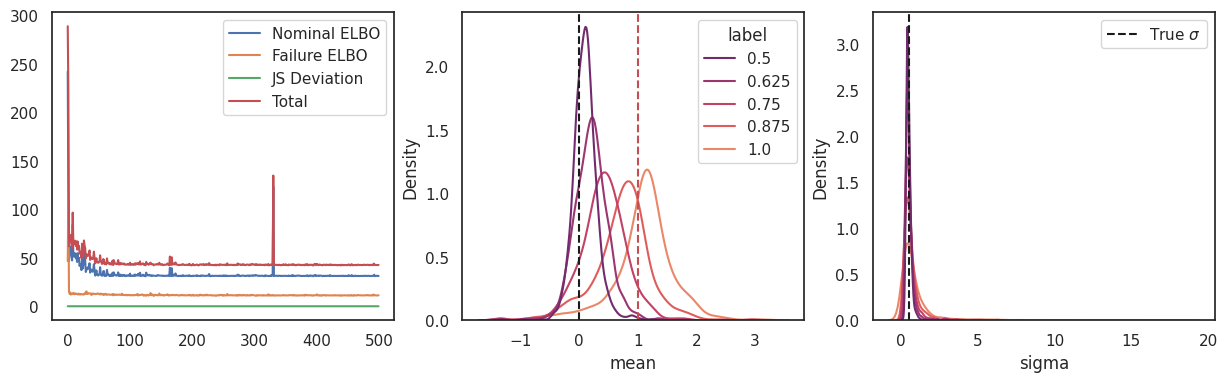

In [8]:
# Plot the losses and the learned posterior
fig, axs = plt.subplots(1, 3, figsize=(15, 4))
axs[0].plot(nominal_elbo_losses, label="Nominal ELBO")
axs[0].plot(failure_elbo_losses, label="Failure ELBO")
axs[0].plot(js_divergence_losses, label="JS Deviation")
axs[0].plot(total_losses, label="Total")
axs[0].legend()

with torch.no_grad():
    plotting_dfs = []

    for label in torch.linspace(0.5, 1.0, 5):
        failure_posterior_samples = flow(torch.tensor([label])).sample((1000,))
        failure_means = failure_posterior_samples[:, 0]
        failure_sigmas = torch.exp(failure_posterior_samples[:, 1]).detach().numpy()
        plotting_dfs.append(
            pd.DataFrame(
                {
                    "mean": failure_means,
                    "sigma": failure_sigmas,
                    "label": label,
                }
            )
        )

    plotting_df = pd.concat(plotting_dfs)

plotting_df["label"] = plotting_df["label"].astype(str)
sns.kdeplot(
    x="mean",
    hue="label",
    data=plotting_df,
    ax=axs[1],
    common_norm=False,
    palette="flare_r",
)
sns.kdeplot(
    x="sigma",
    hue="label",
    data=plotting_df,
    ax=axs[2],
    common_norm=False,
    palette="flare_r",
)

axs[1].axvline(nominal_mean, color="k", linestyle="--", label="True nominal mean")
axs[1].axvline(failure_mean, color="r", linestyle="--", label="True failure mean")
axs[2].axvline(std, color="k", linestyle="--", label="True $\sigma$")
# axs[1].legend(loc="upper left")
axs[2].legend()